In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv('samples_nylonGuitar_1024_Mm7-R02.csv')
X = np.array(df.iloc[:,:-1], dtype = np.float)
y = np.array(df.iloc[:,-1], dtype = np.float)

print (X.shape)
print (y.shape)

(11361, 1024)
(11361,)


In [3]:
print (X[0])
print (y[0])

[-0.02969727 -0.03129398 -0.03199614 ..., -0.0474076  -0.04863384
 -0.04648216]
1.0


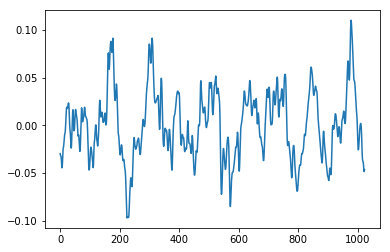

In [4]:
plt.plot(X[0])
plt.show()

In [5]:
pca = PCA(n_components = 1)
pca_result = pca.fit_transform(X)

In [6]:
print(pca_result)

[[ 0.34064638]
 [-0.38977891]
 [ 0.26084678]
 ..., 
 [-0.23697518]
 [-0.2551271 ]
 [-0.02620076]]


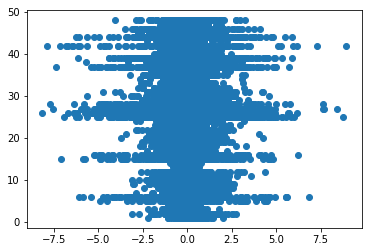

In [7]:
import matplotlib as mpl

plt.scatter(pca_result, y)
mpl.rcParams['figure.figsize'] = (10,10)
plt.show()

In [8]:
for i in range(len(X)):
    if y[i] == 4:
        sample = np.array(X[i], dtype=np.float)
        sample = np.append(sample,y[i])
        try:
            Csamples = np.vstack([Csamples,sample])
        except:
            Csamples = np.array(sample, dtype = np.float)

In [9]:
X = (Csamples[:,:-1])
y = (Csamples[:,-1])

print (X.shape)
print (y.shape)

(142, 1024)
(142,)


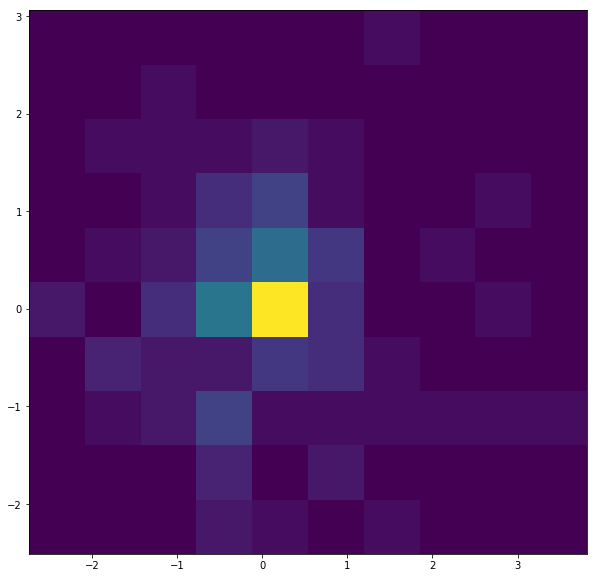

In [10]:
pca = PCA(n_components = 2)
pca_result = pca.fit_transform(X)

plt.hist2d(pca_result[:,0],pca_result[:,1])
plt.show()

In [11]:
import sys
import time
import os
import glob
import numpy
import aifc
import math
from numpy import NaN, Inf, arange, isscalar, array
from scipy.fftpack import rfft
from scipy.fftpack import fft
from scipy.fftpack.realtransforms import dct
from scipy.signal import fftconvolve
from matplotlib.mlab import find
import matplotlib.pyplot as plt
from scipy import linalg as la
from scipy.signal import lfilter, hamming

def stChromagram(signal, Fs, Win, Step, PLOT=False):
    """
    Short-term FFT mag for spectogram estimation:
    Returns:
        a numpy array (nFFT x numOfShortTermWindows)
    ARGUMENTS:
        signal:      the input signal samples
        Fs:          the sampling freq (in Hz)
        Win:         the short-term window size (in samples)
        Step:        the short-term window step (in samples)
        PLOT:        flag, 1 if results are to be ploted
    RETURNS:
    """
    Win = int(Win)
    Step = int(Step)
    signal = np.double(signal)
    signal = signal / (2.0 ** 15)
    DC = signal.mean()
    MAX = (numpy.abs(signal)).max()
    signal = (signal - DC) / (MAX - DC)

    N = len(signal)        # total number of signals
    curPos = 0
    countFrames = 0
    nfft = int(Win / 2)
    nChroma, nFreqsPerChroma = stChromaFeaturesInit(nfft, Fs)
    chromaGram = numpy.array([], dtype=numpy.float64)

    while (curPos + Win - 1 < N):
        countFrames += 1
        x = signal[curPos:curPos + Win]
        curPos = curPos + Step
        X = abs(fft(x))
        X = X[0:nfft]
        X = X / len(X)
        chromaNames, C = stChromaFeatures(X, Fs, nChroma, nFreqsPerChroma)
        C = C[:, 0]
        if countFrames == 1:
            chromaGram = C.T
        else:
            chromaGram = numpy.vstack((chromaGram, C.T))
    FreqAxis = chromaNames
    TimeAxis = [(t * Step) / Fs for t in range(chromaGram.shape[0])]

    if (PLOT):
        fig, ax = plt.subplots()
        chromaGramToPlot = chromaGram.transpose()[::-1, :]
        Ratio = chromaGramToPlot.shape[1] / (3*chromaGramToPlot.shape[0])        
        if Ratio < 1:
            Ratio = 1
        chromaGramToPlot = numpy.repeat(chromaGramToPlot, Ratio, axis=0)
        imgplot = plt.imshow(chromaGramToPlot)
        Fstep = int(nfft / 5.0)
#        FreqTicks = range(0, int(nfft) + Fstep, Fstep)
#        FreqTicksLabels = [str(Fs/2-int((f*Fs) / (2*nfft))) for f in FreqTicks]
        ax.set_yticks(range(Ratio / 2, len(FreqAxis) * Ratio, Ratio))
        ax.set_yticklabels(FreqAxis[::-1])
        TStep = countFrames / 3
        TimeTicks = range(0, countFrames, TStep)
        TimeTicksLabels = ['%.2f' % (float(t * Step) / Fs) for t in TimeTicks]
        ax.set_xticks(TimeTicks)
        ax.set_xticklabels(TimeTicksLabels)
        ax.set_xlabel('time (secs)')
        imgplot.set_cmap('jet')
        plt.colorbar()
        plt.show()

    return (chromaGram, TimeAxis, FreqAxis)

def stChromaFeaturesInit(nfft, fs):
    """
    This function initializes the chroma matrices used in the calculation of the chroma features
    """
    freqs = numpy.array([((f + 1) * fs) / (2 * nfft) for f in range(nfft)])    
    Cp = 27.50    
    nChroma = numpy.round(12.0 * numpy.log2(freqs / Cp)).astype(int)

    nFreqsPerChroma = numpy.zeros((nChroma.shape[0], ))

    uChroma = numpy.unique(nChroma)
    for u in uChroma:
        idx = numpy.nonzero(nChroma == u)
        nFreqsPerChroma[idx] = idx[0].shape
    
    return nChroma, nFreqsPerChroma

def stChromaFeatures(X, fs, nChroma, nFreqsPerChroma):
    #TODO: 1 complexity
    #TODO: 2 bug with large windows

    chromaNames = ['A', 'A#', 'B', 'C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#']
    spec = X**2    
    if nChroma.max()<nChroma.shape[0]:        
        C = numpy.zeros((nChroma.shape[0],))
        C[nChroma] = spec
        C /= nFreqsPerChroma[nChroma]
    else:        
        I = numpy.nonzero(nChroma>nChroma.shape[0])[0][0]        
        C = numpy.zeros((nChroma.shape[0],))
        C[nChroma[0:I-1]] = spec            
        C /= nFreqsPerChroma
    finalC = numpy.zeros((12, 1))
    newD = int(numpy.ceil(C.shape[0] / 12.0) * 12)
    C2 = numpy.zeros((newD, ))
    C2[0:C.shape[0]] = C
    C2 = C2.reshape(C2.shape[0]/12, 12)
    #for i in range(12):
    #    finalC[i] = numpy.sum(C[i:C.shape[0]:12])
    finalC = numpy.matrix(numpy.sum(C2, axis=0)).T
    finalC /= spec.sum()

#    ax = plt.gca()
#    plt.hold(False)
#    plt.plot(finalC)
#    ax.set_xticks(range(len(chromaNames)))
#    ax.set_xticklabels(chromaNames)
#    xaxis = numpy.arange(0, 0.02, 0.01);
#    ax.set_yticks(range(len(xaxis)))
#    ax.set_yticklabels(xaxis)
#    plt.show(block=False)
#    plt.draw()

    return chromaNames, finalC

def stSpectogram(signal, Fs, Win, Step, PLOT=False):
    """
    Short-term FFT mag for spectogram estimation:
    Returns:
        a numpy array (nFFT x numOfShortTermWindows)
    ARGUMENTS:
        signal:      the input signal samples
        Fs:          the sampling freq (in Hz)
        Win:         the short-term window size (in samples)
        Step:        the short-term window step (in samples)
        PLOT:        flag, 1 if results are to be ploted
    RETURNS:
    """
    Win = int(Win)
    Step = int(Step)
    signal = numpy.double(signal)
    signal = signal / (2.0 ** 15)
    DC = signal.mean()
    MAX = (numpy.abs(signal)).max()
    signal = (signal - DC) / (MAX - DC)

    N = len(signal)        # total number of signals
    curPos = 0
    countFrames = 0
    nfft = int(Win / 2)
    specgram = numpy.array([], dtype=numpy.float64)

    while (curPos + Win - 1 < N):
        countFrames += 1
        x = signal[curPos:curPos+Win]
        curPos = curPos + Step
        X = abs(fft(x))
        X = X[0:nfft]
        X = X / len(X)

        if countFrames == 1:
            specgram = X ** 2
        else:
            specgram = numpy.vstack((specgram, X))

    FreqAxis = [((f + 1) * Fs) / (2 * nfft) for f in range(specgram.shape[1])]
    TimeAxis = [(t * Step) / Fs for t in range(specgram.shape[0])]

    if (PLOT):
        fig, ax = plt.subplots()
        imgplot = plt.imshow(specgram.transpose()[::-1, :])
        Fstep = int(nfft / 5.0)
        FreqTicks = range(0, int(nfft) + Fstep, Fstep)
        FreqTicksLabels = [str(Fs / 2 - int((f * Fs) / (2 * nfft))) for f in FreqTicks]
        ax.set_yticks(FreqTicks)
        ax.set_yticklabels(FreqTicksLabels)
        TStep = countFrames/3
        TimeTicks = range(0, countFrames, TStep)
        TimeTicksLabels = ['%.2f' % (float(t * Step) / Fs) for t in TimeTicks]
        ax.set_xticks(TimeTicks)
        ax.set_xticklabels(TimeTicksLabels)
        ax.set_xlabel('time (secs)')
        ax.set_ylabel('freq (Hz)')
        imgplot.set_cmap('jet')
        plt.colorbar()
        plt.show()

    return (specgram, TimeAxis, FreqAxis)

4.0
[  7.71470100e-05   3.71836800e-05   2.62125700e-05 ...,  -6.63245900e-05
  -9.05301200e-05  -1.06585300e-04]
(1024,)


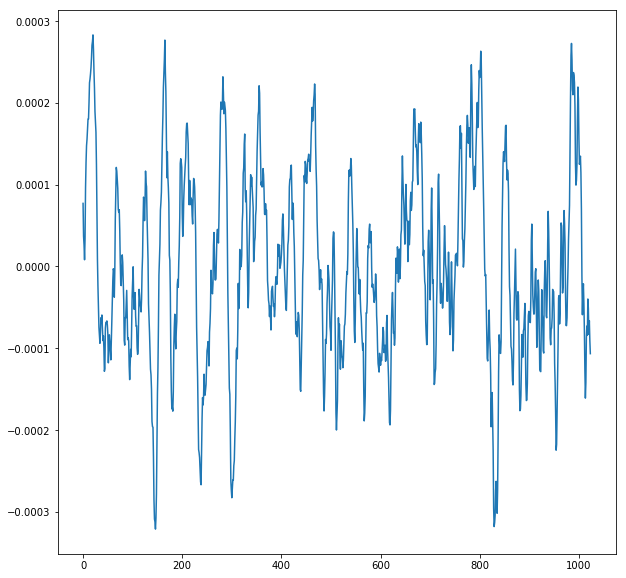

In [12]:
sample = X[0]
print(y[0])
print(sample)
print(sample.shape)
plt.plot(sample)
plt.show()

In [15]:
specgram, TimeAxis, FreqAxis = stChromagram(sample, 44100, 1024, 1024, False)

TypeError: 'float' object cannot be interpreted as an integer

In [ ]:
specgram, TimeAxis, FreqAxis = aF.stSpectogram(x, Fs, round(Fs * 0.040), round(Fs * 0.040), True)

(1L, 12L)
<class 'numpy.matrixlib.defmatrix.matrix'>
[ 0.08473747  0.00089999  0.00037775  0.01636205  0.00075006  0.04537417
  0.00011816  0.00800207  0.01585218  0.00550125  0.00913032  0.00551446]


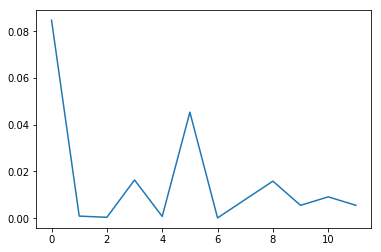

In [9]:
print(specgram.shape)
print(type(specgram))
numpySpec = np.array(specgram, dtype=np.float)

print (numpySpec[0])

plt.plot(numpySpec[0])
plt.show()